# Pan-cancer (PC) plasma proteome Paper — Figure 4

This Jupyter Notebook (with Python 3 kernel) contained the code for the proteomic analysis of the characteristic of different tumor types and the subtypes of the LC

Input files:  
* The categorical clinical file: category.csv
* The continuous clinical fille: continuous.csv
* The PC proteome file: proteome.csv

Output figures:  
* Figure 4a, 4b, 4c, 4d, 4e, 4f, 4h, 4i, 4j, S7a

In [1]:
from utils import *
paths = ['../figure/figure4', '../documents/figure4']
for path in paths:
    if not os.path.isdir(path):
        os.makedirs(path)

a = Analysis('../')

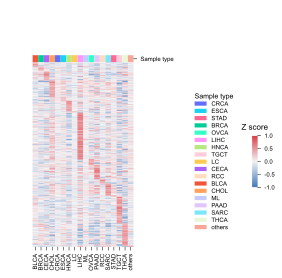

In [4]:
from utils.function import large_than_n_value

tumor_types = a.category['Sample type'].dropna().unique()
tumor_types = [i for i in tumor_types if 'benign' not in i if i != 'normal']
a.set_param('group', dataset_type='proteome', group_name=['sample_annot', 'Sample type'], part_element=[['discovery_tumor'], tumor_types], param_method='mean')
df = a.table.query('kruskal_pvalues<0.05').filter(like='mean')
df.to_csv('../documents/figure4/Fig4a_comparison_table.csv')

large_than_ = large_than_n_value(df).sort_index(axis=1)
order_ = large_than_.sort_values(large_than_.columns.tolist(), ascending=[False]*large_than_.shape[1]).index
plotdata = a.merge_data_group(order_).apply(scipy.stats.zscore, nan_policy='omit').groupby('Sample type').mean().T
plotdata.to_csv('../documents/figure4/Source_data_Fig4a.csv')

palette = {k: v for k, v in a._color_map['Sample type'].items() if 'benign' not in k if k != 'normal'}
fig = heatmap(plotdata, yticklabels=False, xticklabels=True, lut={'Sample type': palette}, figsize=(2.5, 4), cbar_pos=(1.4, .35, .03, .18))
fig.ax_cbar.set_title('Z score')
fig.savefig('../figure/figure4/Fig4a.pdf', bbox_inches='tight')

In [5]:
o = ora('clusterprofiler')
enrich_table = pd.DataFrame()
for tumor_type in large_than_.columns:
    query_condition_ = f"{tumor_type}==True"
    gene = large_than_.query(query_condition_).index.tolist()
    enrich_table_tmp = o.run(gene, db=['hallmark', 'kegg', 'reac', 'go'])
    enrich_table_tmp.insert(0, 'Tumor type', tumor_type.rsplit('_', maxsplit=1)[0])
    enrich_table = pd.concat([enrich_table, enrich_table_tmp])
enrich_table.to_csv('../documents/figure4/Fig4a_enrichment_table.csv')

R[write to console]: Loading required package: AnnotationDbi

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


R[write to console]: Loading required package: Biobase

R[write to console]: Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()

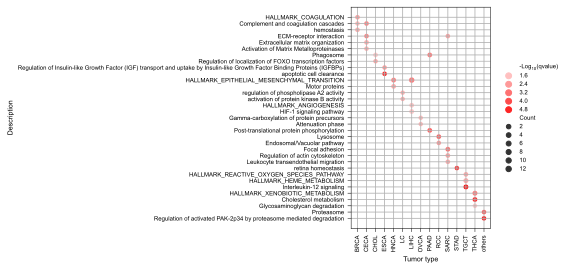

In [17]:
import matplotlib.colors as mcolors
cmap = mcolors.LinearSegmentedColormap.from_list("red_blue_gradient", ['#FFCACA', '#fc0000'], N=256)

terms = {
    'discovery_tumor_BRCA': ['HALLMARK_COAGULATION', 'Complement and coagulation cascades', 'hemostasis'], 
    'discovery_tumor_CECA': ['Complement and coagulation cascades', 'ECM-receptor interaction', 'Extracellular matrix organization', 'Activation of Matrix Metalloproteinases'],
    'discovery_tumor_CHOL': ['Phagosome', 'Regulation of localization of FOXO transcription factors'],
    'discovery_tumor_ESCA': ['Regulation of Insulin-like Growth Factor (IGF) transport and uptake by Insulin-like Growth Factor Binding Proteins (IGFBPs)', 'apoptotic cell clearance'],
    'discovery_tumor_HNCA': ['HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'Motor proteins'],
    'discovery_tumor_LC': ['activation of protein kinase B activity', 'regulation of phospholipase A2 activity'],
    'discovery_tumor_LIHC': ['HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'HALLMARK_ANGIOGENESIS', 'HIF-1 signaling pathway'],
    'discovery_tumor_OVCA': ['Gamma-carboxylation of protein precursors', 'Attenuation phase'],
    'discovery_tumor_PAAD': ['Phagosome', 'Post-translational protein phosphorylation'],
    'discovery_tumor_RCC': ['Lysosome', 'Endosomal/Vacuolar pathway'],
    'discovery_tumor_SARC': ['Focal adhesion', 'ECM-receptor interaction', 'Regulation of actin cytoskeleton', 'Leukocyte transendothelial migration'],
    'discovery_tumor_STAD': ['retina homeostasis'],
    'discovery_tumor_TGCT': ['HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY', 'HALLMARK_HEME_METABOLISM', 'Interleukin-12 signaling'],
    'discovery_tumor_THCA': ['HALLMARK_XENOBIOTIC_METABOLISM', 'Cholesterol metabolism', 'Glycosaminoglycan degradation'],
    'discovery_tumor_others': ['Proteasome', 'Regulation of activated PAK-2p34 by proteasome mediated degradation']
}

plotdata = pd.DataFrame()
for k, v in terms.items():
    tmp_plotdata = enrich_table.query("`Tumor type`==@k&Description in @v")[['Tumor type', 'Description', 'qvalue', 'Count']]
    plotdata = pd.concat([plotdata, tmp_plotdata])
plotdata = plotdata.assign(qvalue=-np.log10(plotdata['qvalue'])).rename(columns={'qvalue': '-$\mathregular{Log_{10}}$(qvalue)'})
plotdata.to_csv('../documents/figure4/Source_data_Fig4b.csv')

ax = scatterplot(plotdata, figsize=(2.5, 4), spines_hide=[], palette=cmap, sizes=(20, 30), ticklabels_wrap=[], ticklabels_hide=[], ticklabels_format=[])
ax.set_xticklabels([i.split('_')[-1] for i in terms.keys()], rotation=90)
ax.grid()
ax.get_figure().savefig('../figure/figure4/Fig4b.pdf', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


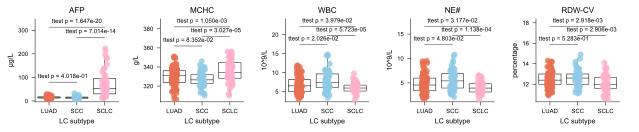

In [6]:
a.set_param('group', dataset_type='continuous', group_name='LC subtype')
fig, axs = plt.subplots(1, 5, figsize=(10.5, 1.5))
plt.subplots_adjust(wspace=.5)
for ax, clinical_indicator, ylabel in zip(axs, ['AFP', 'MCHC', 'WBC', 'NE#', 'RDW-CV'], ['µg/L', 'g/L', '10^9/L', '10^9/L', 'percentage']):
    plotdata, _ = a.cate(clinical_indicator, ax=ax, text_format='full', category_type=['box', 'strip'], spines_hide=['right', 'top'], quantile=True, method='ttest', return_data=True)
    ax.set_ylabel(ylabel)
    plotdata.to_csv('../documents/figure4/Source_data_Fig4c_{}.csv'.format(clinical_indicator))
fig.savefig('../figure/figure4/Fig4c.pdf', bbox_inches='tight')

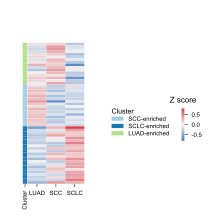

In [7]:
from sklearn.cluster import KMeans
from utils.function import sort_custom

a.set_param('group', dataset_type='proteome', group_name='LC subtype')
cluster_genes = a.table.query("kruskal_pvalues<0.05").index
df = a.merge_data_group(cluster_genes).apply(scipy.stats.zscore, nan_policy='omit').groupby('LC subtype').mean().T

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(df)
cluster_df = pd.Series(cluster_labels, index=cluster_genes).rename('Cluster').to_frame()
cluster_df = sort_custom(cluster_df, 'Cluster', [2, 0, 1])
cluster_names = ['SCC-enriched', 'SCLC-enriched', 'LUAD-enriched']
cluster_name_mapping = dict(zip([0, 1, 2], cluster_names))
cluster_df['Cluster'] = cluster_df['Cluster'].map(cluster_name_mapping)

plotdata = pd.concat([cluster_df, df], axis=1).set_index('Cluster', append=True)
plotdata.to_csv('../documents/figure4/Source_data_Fig4d.csv')

fig = heatmap(plotdata, yticklabels=False, figsize=(1.4, 3), xticklabels=True, lut={'Cluster': dict(zip(cluster_names, MCMAP[:3]))}, cbar_pos=(1.8, .35, .03, .15), colors_ratio=.06, vmax=.8, vmin=-.8)
fig.ax_cbar.set_title('Z score')
fig.savefig('../figure/figure4/Fig4d.pdf', bbox_inches='tight')

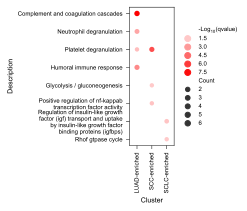

In [9]:
import matplotlib.colors as mcolors
cmap = mcolors.LinearSegmentedColormap.from_list("red_blue_gradient", ['#FFCACA', '#fc0000'], N=256)

o = ora('clusterprofiler')
enrich_df = cluster_df.groupby('Cluster').apply(lambda x: o.run(x.index.tolist(), db=['kegg', 'reac', 'go', 'hallmark']))
enrich_df.to_csv('../documents/figure4/Fig4e_enrichment_table.csv')

term = ['Complement and coagulation cascades', 'Neutrophil degranulation', 'Platelet degranulation', 'humoral immune response', 'Glycolysis / Gluconeogenesis', 'Platelet degranulation', 'positive regulation of NF-kappaB transcription factor activity', 'Regulation of Insulin-like Growth Factor (IGF) transport and uptake by Insulin-like Growth Factor Binding Proteins (IGFBPs)', 'RHOF GTPase cycle']
plotdata = enrich_df.query("Description in @term")[['Description', 'qvalue', 'Count']].droplevel(1)
plotdata['Description'] = plotdata['Description'].str.replace('HALLMARK', '').str.replace('_', ' ').str.capitalize()
plotdata = plotdata.assign(qvalue=-np.log10(plotdata['qvalue'])).rename(columns={'qvalue': '-$\mathregular{Log_{10}}$(qvalue)'}).reset_index()
plotdata.to_csv('../documents/figure4/Source_data_Fig4e.csv')

ax = scatterplot(plotdata, figsize=(.8, 2.5), spines_hide=[], palette=cmap, sizes=(20, 30), wrap_length=35, ticklabels_hide=[], ticklabels_format=[])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlim([-.5, 2.5])
ax.get_figure().savefig('../figure/figure4/Fig4e.pdf', bbox_inches='tight')

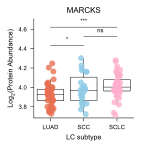

In [24]:
a.set_param('group', dataset_type='proteome', group_name='LC subtype')
plotdata, axs = a.cate(['MARCKS'], value_log_transform='log2', method='ttest', one_tail=True, spines_hide=['right', 'top'], category_type=['box', 'strip'], return_data=True)
plotdata.to_csv('../documents/figure4/Source_data_Fig4f.csv')

ax = axs[0]
ax.set_ylabel('$\mathregular{Log_2}$(Protein Abundance)')
ax.get_figure().savefig('../figure/figure4/Fig4f.pdf', bbox_inches='tight')

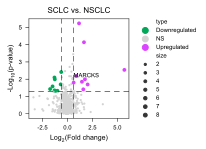

In [20]:
a._data['tmp'] = 2 ** a.proteome
a.set_param('group', dataset_type='tmp', group_name='LC subtype binary', part_element=['SCLC', 'NSCLC'], dividend='SCLC')
plotdata, ax = a.scatter(['SCLC_vs_NSCLC', 'ttest_pvalues'], volcano=True, ratio_cutoff=1.5, highlight_points=['MARCKS'], return_data=True)
plotdata.to_csv('../documents/figure4/Source_data_FigS7a.csv')
ax.get_figure().savefig('../figure/figure4/FigS7a.pdf', bbox_inches='tight')

In [11]:
a.set_param('group', dataset_type='proteome', group_name='LC subtype binary')
ml_data = a.merge_data_group(['MCHC', 'WBC', 'AFP', 'MARCKS'], data_type=['continuous', 'proteome']).drop('AFP|proteome', axis=1).dropna(how='all')
ml_data.columns = ml_data.columns.map(lambda x: x.split('|')[0])
ml_data.to_csv('../documents/figure4/ml/ml_data.csv')

In [12]:
final_model_ = {
    'WBC': ['LC_subtype_KNeighborsClassifier_tuned_model.joblib', 'LC_subtype_KNeighborsClassifier_tuned_model_train-test.joblib'],
    'MCHC': ['LC_subtype_ExtraTreesClassifier_tuned_model.joblib', 'LC_subtype_ExtraTreesClassifier_tuned_model_train-test.joblib'],
    'AFP': ['LC_subtype_RandomForestClassifier_tuned_model.joblib', 'LC_subtype_RandomForestClassifier_tuned_model_train-test.joblib'],
    'AFP+MCHC+WBC': ['LC_subtype_ExtraTreesClassifier_tuned_model.joblib', 'LC_subtype_ExtraTreesClassifier_tuned_model_train-test.joblib'],
    'AFP+MCHC+WBC+MARCKS': ['LC_subtype_ExtraTreesClassifier_tuned_model.joblib', 'LC_subtype_ExtraTreesClassifier_tuned_model_train-test.joblib']
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


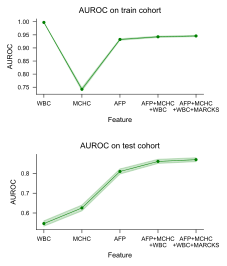

In [13]:
import joblib
path = '../documents/figure4/ml/final_model'
evaluate_df_combine = pd.DataFrame()
for feature_, (_, evaluate_file_name_) in final_model_.items():
    evaluate_ = joblib.load(os.path.join(path, evaluate_file_name_.replace('LC_subtype', 'LC_subtype_'+feature_)))['all']
    evaluate_df = pd.concat([pd.DataFrame().from_dict(v, orient='index').assign(random_state=k) for k, v in evaluate_.items()]).assign(feature=feature_)
    evaluate_df_combine = pd.concat([evaluate_df_combine, evaluate_df])
evaluate_df_combine.to_csv('../documents/figure4/Fig4h_evaluated_scores.csv')

fig, axs = plt.subplots(2, 1, figsize=(3, 3.8))
plt.subplots_adjust(hspace=.8)

for i, cohort in enumerate(['train', 'test']):
    ax = evaluate_df_combine.loc[cohort, ['feature', 'AUROC']].pipe(lineplot, ticklabels_format=[], ticklabels_hide=[], figsize=(3, 1.5), color='green', ax=axs[i])
    ax = evaluate_df_combine.loc[cohort].groupby('feature', sort=False)['AUROC'].mean().pipe(scatterplot, ticklabels_format=[], ticklabels_hide=[], color='green', s=10, ax=axs[i])
    ax.set_xticklabels(['WBC', 'MCHC', 'AFP', 'AFP+MCHC\n+WBC', 'AFP+MCHC\n+WBC+MARCKS'])
    ax.set_xlabel('Feature')
    ax.set_title(f'AUROC on {cohort} cohort')
fig.savefig('../figure/figure4/Fig4h.pdf', bbox_inches='tight')
evaluate_df_combine[['feature', 'AUROC']].to_csv('../documents/figure4/Source_data_Fig4h.csv')

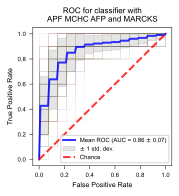

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.preprocessing import LabelEncoder

X = ml_data.dropna().values
y = ml_data.dropna().index.get_level_values(1)

model = joblib.load(os.path.join(os.path.join(path, final_model_['AFP+MCHC+WBC+MARCKS'][0].replace('LC_subtype', 'LC_subtype_'+feature_))))
clf = model.steps[1][1]

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
for random_state in range(1, 101, 1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, stratify=y, random_state=random_state)
    
    clf.fit(X_train, y_train)
    le = LabelEncoder().fit(y_test)

    viz = RocCurveDisplay.from_estimator(clf, X_test, y_test, alpha=.2, lw=.3, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC for classifier with\nAPF MCHC AFP and MARCKS")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-3:], labels[-3:], loc='lower right', fontsize=6)
ax.get_figure().savefig('../figure/figure4/Fig4i.pdf', bbox_inches='tight')

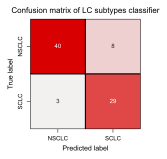

In [16]:
from sklearn.metrics import confusion_matrix

X = ml_data.dropna().values
y = ml_data.dropna().index.get_level_values(1)
clf.fit(X, y)

cm = confusion_matrix(y, clf.predict(X))
label = np.unique(y)

ax = heatmap(pd.DataFrame(cm, index=label, columns=label), vmax=cm.max().max(), vmin=cm.min().min(), center=None, annot=True, square=True, xticklabels=True, fmt='.0f', cmap=R_CMAP, cbar=False, linewidth=1, linecolor='black', figsize=(2, 2))
ax.set_title('Confusion matrix of LC subtypes classifier')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.get_figure().savefig('../figure/figure4/Fig4j.pdf', bbox_inches='tight')